# The average age of a selected allele

This is an example of an I/O bound process.  We write the frequency trajectories to sqlite3 databases.  We use threadsafe queues to take data from processes to the database.  Eventually, the sims are done and we have to wait for the queue to write.  The advantage of this design over a lock is that simulation processes won't block each other while writing (which they would when using a multiprocessing.Lock).

In [1]:
%load_ext rpy2.ipython

In [2]:
import fwdpy as fp
import numpy as np
import pandas as pd
import os
import sqlite3
import multiprocessing as mp

In [3]:
def run_sim(args):
    q,seed,repid,nreps=args
    
    #We will simulate no neutral mutations
    nregions = []

    pweight=1e-3
    bgs_weight = (1.-1e-3)/2.
    #These are our "BGS loci"
    sregions = [fp.ConstantS(beg=-1,end=0,weight=bgs_weight,s=-0.05,h=1),
                fp.ConstantS(beg=1,end=2,weight=bgs_weight,s=-0.05,h=1)]
    
    sregions.append(fp.ConstantS(beg=0,end=1,weight=pweight,s=0.025,h=1))

    #Recombination is uniform across whole region
    recregions = [fp.Region(beg=-1,end=2,weight=1)]

    #Population size
    N=1000
    ##Evolve for 20N generations with constant N
    nlist = np.array([N]*20*N,dtype=np.uint32)

    #Random number generator
    rng = fp.GSLrng(seed)

    sampler=fp.FreqSampler(1)
    pops = fp.SpopVec(1,N)
    for rep in range(nreps):
        fp.evolve_regions_sampler(rng,pops,sampler,       
                                  nlist[0:],
                                  0.000, #No neutral variants
                                  0.01,     
                                  0.005,    
                                  [],    #No neutral variants
                                  sregions, 
                                  recregions,
                                  1)
        #Get the trajectories of every selected mutation.
        #We filter on mutation origin time, only taking mutations
        #that first arose after 8N generations.
        #The fp.FreqSampler.fetch method allows Python callbacks for filtering.
        #Here, we filter on the first generation being >= 8*N
        traj = sampler.fetch(0,freq_filter = lambda x : x[0][0] >= 8*N)
        #add an id for this replicate
        traj['rep'] = [repid*nreps+rep]*len(traj.index)
        q.put(traj)
    return

In [4]:
def writer(q,dbname,tablename,nreps):
    #done=0
    con = sqlite3.connect(dbname)
    #Various sqlite3 pragma to
    #improve performance
    con.execute("PRAGMA synchronous=OFF")
    con.execute("PRAGMA count_changes=OFF")
    con.execute("PRAGMA journal_mode=MEMORY")
    con.execute("PRAGMA cache_size(10000)")
    con.execute("PRAGMA temp_store=MEMORY")
    while True:
        msg=q.get()
        if isinstance(msg,pd.DataFrame):
            #Do not write index as we go.
            msg.to_sql(tablename,con,if_exists='append',index=False)
        else:
            break
            #++done
    #Now, add index on the way out
    con.execute("create index if not exists gen_esize on "+tablename+" (generation,esize)")
    con.close()

In [5]:
DBNAME='trajectories.db'
if os.path.isfile(DBNAME):
    os.remove(DBNAME)
np.random.seed(101)

m=mp.Manager()
q=m.Queue()

#We will do 80 replicates
#by running 40 batches of 2
#replicates each
nproc=40
nreps_per_proc=2
qp = mp.Process(target=writer,args=(q,DBNAME,'freqs',nproc))
qp.start()
#Generate the arguments to pass to simulate_async.
#The arguments for mp.Pool.imap_unordered must be a tuple.
#Our list of arguments will be 'nproc' elements long. Each tuple
#contains a random seed.  If this were a study for publication,
#I would be more careful and guarantee that each seed is unique.
args=[(q,seed,repid,nreps_per_proc) for seed,repid in zip(np.random.randint(0,42000000,nproc),range(nproc))]
#P a thread pool using the number of processors on your machine
#If you have < nproc cores, it'll spawn new processes as old ones finish.
P=mp.Pool() 
#Pass the arguments along to the process pool.
#This will run 'nproc*nreps_per_proc' replicate simulations
#and output data from each to our sqlite3 
#database.
P.imap_unordered(run_sim,args)
P.close()
P.join()  #Block on the pool until it completes its work
q.put("done") #signal the queue's process that the pool is done
qp.join()  #Block on the queue's process until it is finished

In [6]:
%R require(dplyr)

/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: dplyr

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/dist-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

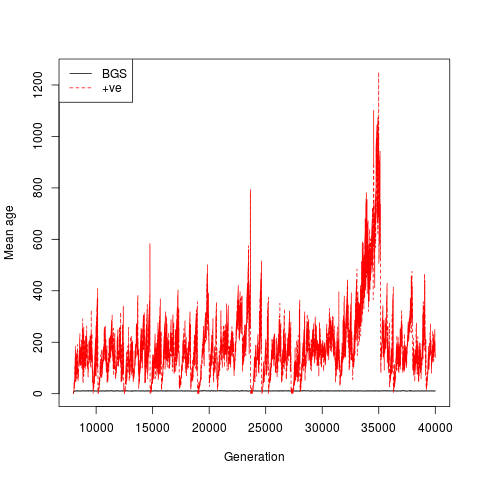

In [9]:
%%R
db <- src_sqlite('trajectories.db')
data <- tbl(db,'freqs')

#Get mean age of deleterious variants over time
qdel = data %>% filter(esize<0) %>% group_by(generation) %>% summarise(mean_age = mean(generation-origin))
#ditto for +ve-ly selected variants
qpos = data %>% filter(esize>0) %>% group_by(generation) %>% summarise(mean_age = mean(generation-origin))

del=collect(qdel)
pos=collect(qpos)
plot(del$generation,del$mean_age,xlab="Generation",ylab="Mean age",type='l',ylim=c(0,max(pos$mean_age)))
lines(pos$generation,pos$mean_age,col="red",lty="dashed")
legend('topleft',c("BGS","+ve"),lty=c('solid','dashed'),col=c('black','red'))